 - hash name
 - get python types from function type
 - add a compile function that takes (name, input types, output types) and returns a callable

In [1]:
from pathlib import Path

from xdsl.builder import ImplicitBuilder
from xdsl.dialects import arith, func, memref, scf
from xdsl.dialects.builtin import ArrayAttr, DictionaryAttr, FloatAttr, IndexType, IntegerAttr, ModuleOp, UnitAttr, f64, i64
from xdsl.ir import Block, Region

index = IndexType()

def get_module(n: int) -> ModuleOp:
    memref_t = memref.MemRefType(f64, [n])
    module = ModuleOp([])
    with ImplicitBuilder(module.body):
        f = func.FuncOp("hello", ((i64, i64), (i64,)))
        with ImplicitBuilder(f.body) as (lhs, rhs):
            res = arith.Addi(lhs, rhs).result
            func.Return(res)

        g = func.FuncOp("dist", ((memref_t, memref_t), (f64,)), arg_attrs=ArrayAttr((DictionaryAttr({"llvm.noalias": UnitAttr()}),) * 2))
        with ImplicitBuilder(g.body) as (lhs, rhs):
            zero = arith.Constant(IntegerAttr( 0, index)).result
            one = arith.Constant(IntegerAttr( 1, index)).result
            hundo = arith.Constant(IntegerAttr( n, index)).result

            initial = arith.Constant(FloatAttr(0.0, f64)).result

            body = Region(Block(arg_types=(index, f64)))
            norm_squared = scf.For(zero, hundo, one, (initial,), body)
            with ImplicitBuilder(norm_squared.body) as (i, acc):
                lhs_el = memref.Load.get(lhs, (i,)).res
                rhs_el = memref.Load.get(rhs, (i,)).res
                sq = arith.Mulf(lhs_el, rhs_el).result
                new_acc = arith.Addf(acc, sq)
                scf.Yield(new_acc)

            func.Return(norm_squared)

    return module

m = get_module(100)
m_str = str(m)

with open(Path() / "input.mlir", 'w') as f:
    f.write(m_str)

In [2]:
import ctypes

from xdsl.jit import jit_module

dbl_ptr_type = ctypes.POINTER(ctypes.c_double)

hey = jit_module(m, "hello", types=((int, int), int))
dist_mlir = jit_module(m, "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
hey(5,6)

11

In [3]:
import numpy as np

In [4]:
n = 10000
a = np.random.random(n)
b = np.random.random(n)

In [5]:
a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
%time dist_mlir(a_data_ptr, b_data_ptr)

CPU times: user 131 µs, sys: 2 µs, total: 133 µs
Wall time: 8.11 µs


21.8160325411919

In [6]:
%time hey(5, 6)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 10 µs


11

In [7]:
%time 1 + 2

CPU times: user 1 µs, sys: 6 µs, total: 7 µs
Wall time: 5.72 µs


3

In [8]:
from typing import Any


def dist_np(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    return lhs.dot(rhs)

%time dist_np(a, b)

CPU times: user 19 µs, sys: 7 µs, total: 26 µs
Wall time: 21.9 µs


2511.187216316052

In [9]:
def dist_python(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    res = np.float64(0.0)
    for l, r in zip(lhs, rhs):
        res += l * r
    return res

%time dist_python(a, b)

CPU times: user 4.89 ms, sys: 89 µs, total: 4.98 ms
Wall time: 926 µs


2511.187216316052

In [10]:
import timeit

timeit.timeit(lambda: dist_python(a, b), number=100)

0.1650540002156049

In [11]:
import pandas as pd

In [12]:
from collections import defaultdict

In [13]:
res = defaultdict[str, list[float]](list)

powers = [int(10 ** i) for i in range(1, 6)]

for n in powers:
    a = np.random.random(n)
    b = np.random.random(n)
    dist_mlir_i = jit_module(get_module(n), "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
    a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
    b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
    res["mlir"].append(timeit.timeit(lambda: dist_mlir_i(a_data_ptr, b_data_ptr), number=100))
    res["numpy"].append(timeit.timeit(lambda: dist_np(a, b), number=100))
    res["python"].append(timeit.timeit(lambda: dist_python(a, b), number=100))

res

defaultdict(list,
            {'mlir': [0.00024062511511147022,
              0.00032595801167190075,
              0.000627957982942462,
              0.005876334151253104,
              0.0560926659964025],
             'numpy': [0.00035629188641905785,
              3.845803439617157e-05,
              7.995800115168095e-05,
              0.0005709999240934849,
              0.00461833318695426],
             'python': [0.00016129203140735626,
              0.0009625419043004513,
              0.008958333870396018,
              0.08824299997650087,
              0.9637316660955548]})

In [14]:
df = pd.DataFrame(res, index=powers)
df

,mlir,numpy,python
10,0.000241,0.000356,0.000161
100,0.000326,0.000038,0.000963
1000,0.000628,0.000080,0.008958
10000,0.005876,0.000571,0.088243
100000,0.056093,0.004618,0.963732


In [15]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


<Axes: ylabel='seconds'>

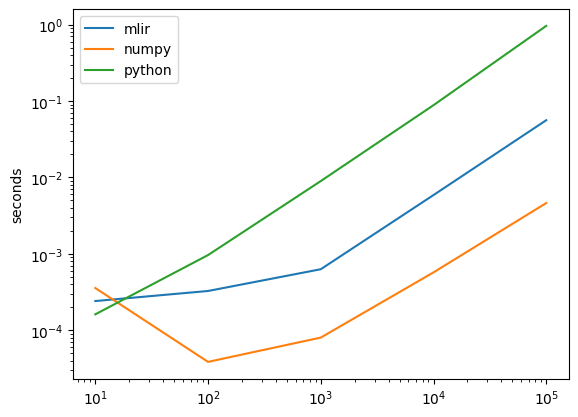

In [16]:
df.plot(logy=True, logx=True, ylabel="seconds")